In [11]:
import time
import sys

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
# from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

sys.path.append("/home/isidro/Documents/github/nnogada/")
from nnogada import Nnogada

np.random.seed(0)

In [12]:
# tf.config.list_physical_devices('GPU')


In [13]:
data_folder = 'Data_SNIa_LSST/'
df_data = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [14]:
df_data['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

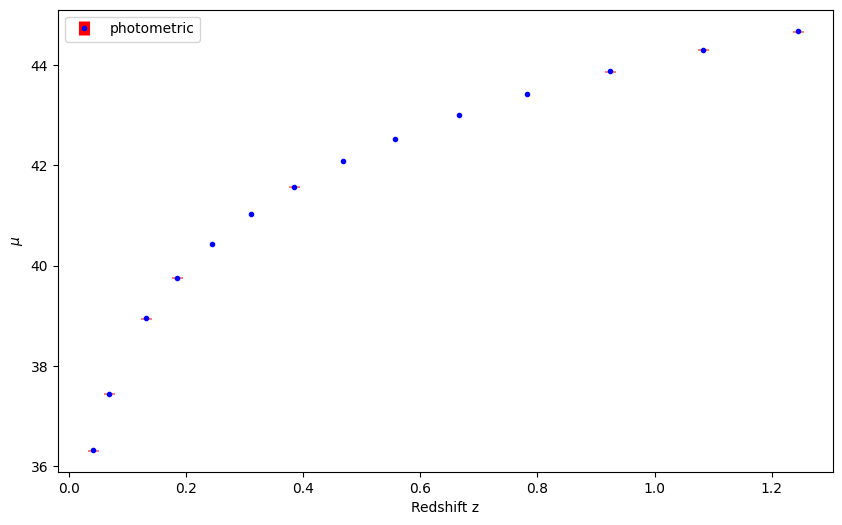

In [15]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [16]:
df_data['errors'] = df_data['MUERR_SYS'].values+df_data['MUERR_SYS'].values
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [17]:
type(df_data)

pandas.core.frame.DataFrame

In [18]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [19]:
df_data.head(), len(df_data)

(      zCMB        MU   errors
 0  0.04131  36.31666  0.01348
 1  0.06876  37.44798  0.01254
 2  0.13121  38.94492  0.01736
 3  0.18499  39.75545  0.01316
 4  0.24503  40.42469  0.01180,
 14)

In [20]:
noise1x = 0.005*np.random.rand(len(df_data))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(df_data))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1

In [21]:
z_or = df_data.values[:,0]
y_or = df_data.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


In [22]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z_sc = scalerz.transform(z.reshape(-1,1))
np.shape(z_sc)

(42, 1)

In [23]:
split = 0.9
ntrain = int(split * len(z))

randomize = np.random.permutation(len(z))
z = z_sc[randomize]
y = y[randomize]

indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(z_test), np.shape(y_train), np.shape(y_test)

((37, 1), (5, 1), (37, 2), (5, 2))

In [25]:
yy_train = np.append(y_train, np.array([y_or[0], y_or[-1]]), axis=0)
zz_train = np.append(z_train, np.array([z_sc[0], z_sc[-1]])).reshape(-1,1)
np.shape(zz_train), np.shape(yy_train)

((39, 1), (39, 2))

In [27]:
np.shape(yy_train)

(39, 2)

In [29]:
population_size = 4  # max of individuals per generation
max_generations = 10    # number of generations
gene_length = 8        # lenght of the gene, depends on how many hiperparameters are tested 2*hyp
k = 1                  # num. of finalist individuals

t = time.time()
datos = []

# Define the hyperparameters for the search
hyperparams = {'deep': [3, 4], 'num_units': [100, 200], 'batch_size': [8, 16, 32, 64]}

# generate a Nnogada instance
net_fit = Nnogada(hyp_to_find=hyperparams, X_train=zz_train, Y_train=yy_train, X_val=z_test, Y_val=y_test, 
                  neural_library='keras', regression=True)
# Set the possible values of hyperparameters and not use the default values from hyperparameters.py
net_fit.set_hyperparameters()

Using CPU


In [30]:
# best solution
best_population = net_fit.ga_with_elitism(population_size, max_generations, gene_length, k)

  0%|                                                                                                                             | 0/10 [00:00<?, ?it/s]2023-08-09 18:46:56.386883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-09 18:46:56.386942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: isidro-PC
2023-08-09 18:46:56.386955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: isidro-PC
2023-08-09 18:46:56.387171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-08-09 18:46:56.387215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.125.6
2023-08-09 18:46:56.387225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version s


Best 5 solutions:
-----------------

   deep  num_units  batch_size      loss     score      time
0     4        200           8  0.004869  0.004869  7.926574
1     3        200           8  0.007280  0.007280  7.539268
2     4        200           8  0.007957  0.007957  7.132889
3     4        200           8  0.008098  0.008098  5.858260
4     4        200           8  0.008241  0.008241  6.644493


In [31]:
print(best_population)
print("Total elapsed time:", (time.time()-t)/60, "minutes")

[[1, 1, 0, 0, 0, 0, 0, 0]]
Total elapsed time: 2.7381152550379437 minutes
